In [1]:
%cd ..

/pub/hofmann-scratch/glanzillo/mammoth


In [2]:

import importlib
import math
import os
import socket
import sys
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
from matplotlib.collections import LineCollection

import time
mammoth_path = os.path.abspath(os.path.join('.'))
if mammoth_path not in sys.path:
    print(mammoth_path)
    sys.path.append(mammoth_path)
    sys.path.append(mammoth_path + '/datasets')
    sys.path.append(mammoth_path + '/backbone')
    sys.path.append(mammoth_path + '/models')
    sys.path.append(mammoth_path + '/utils')


import datetime
import uuid
from argparse import ArgumentParser

import setproctitle
import torch

from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.datasets import ImageNet, ImageFolder
from torchvision.models import efficientnet_v2_s, resnet50, ResNet50_Weights, resnet18
import torchvision.transforms as transforms


/pub/hofmann-scratch/glanzillo/mammoth


In [3]:
%ls

LICENSE    gem_license   models/           seq_cifar10.gif  wandb/
README.md  logo.png      perm_mnist.gif    seq_mnist.gif
backbone/  logs/         requirements.txt  seq_tinyimg.gif
data/      logs.txt      rot_mnist.gif     tests/
datasets/  mnist360.gif  scripts/          utils/


In [6]:
logs_path = './logs/results/imagenet/resnet50/logs.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))

In [7]:
res_df = pd.DataFrame(results)
res_df

/local/home/glanzillo/.local/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/local/home/glanzillo/.local/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


distributed   lr  checkpoints  pretrained  optim_wd  optim_mom  \
0            no  0.1         True       False    0.0001        0.9   
1            no  0.1         True       False    0.0001        0.9   
2            no  0.1         True       False    0.0001        0.9   
3            no  0.1         True       False    0.0001        0.9   
4            no  0.1         True       False    0.0001        0.9   
..          ...  ...          ...         ...       ...        ...   
256          no  0.1         True       False    0.0001        0.9   
257          no  0.1         True       False    0.0001        0.9   
258          no  0.1         True       False    0.0001        0.9   
259          no  0.1         True       False    0.0001        0.9   
260          no  0.1         True       False    0.0001        0.9   

     optim_nesterov  n_epochs  batch_size  validate_subset  ...  \
0                 0        90          64             1000  ...   
1                 0        90          64             1000  ...   
2                 0        90          64             1000  ...   
3                 0        90          64             1000  ...   
4                 0        90          64             1000  ...   
..              ...       ...         ...              ...  ...   
256               0        90          64             2000  ...   
257               0        90          64             2000  ...   
258               0        90          64             2000  ...   
259               0        90          64             2000  ...   
260               0        90          64             2000  ...   

    final_train_leftout_acc_S  final_val_acc_S    MSE  optim_adam  \
0                    0.767263            1.168    NaN         NaN   
1                    1.023018            1.234    NaN         NaN   
2                    0.767263            1.400    NaN         NaN   
3                    1.023018            1.232    NaN         NaN   
4                    1.534527            1.266    NaN         NaN   
..                        ...              ...    ...         ...   
256                 34.526854           34.482  False       False   
257                 50.127877           51.560  False       False   
258                 42.455243           42.500  False       False   
259                  8.695652            8.668  False       False   
260                 48.081841           49.270  False       False   

     optim_warmup  optim_cosineanneal  n_epochs_stud  distillation_type  \
0             NaN                 NaN            NaN                NaN   
1             NaN                 NaN            NaN                NaN   
2             NaN                 NaN            NaN                NaN   
3             NaN                 NaN            NaN                NaN   
4             NaN                 NaN            NaN                NaN   
..            ...                 ...            ...                ...   
256           0.0               False           90.0         topbottomK   
257           0.0               False           90.0            randomK   
258           0.0               False           90.0            randomK   
259           0.0               False           90.0            randomK   
260           0.0               False           90.0            randomK   

         K N_BLOCKS  
0      NaN      NaN  
1      NaN      NaN  
2      NaN      NaN  
3      NaN      NaN  
4      NaN      NaN  
..     ...      ...  
256   50.0      1.0  
257  500.0      1.0  
258  100.0      1.0  
259   10.0      1.0  
260  200.0      1.0  

[261 rows x 39 columns]

In [8]:
res_df.columns

Index(['distributed', 'lr', 'checkpoints', 'pretrained', 'optim_wd',
       'optim_mom', 'optim_nesterov', 'n_epochs', 'batch_size',
       'validate_subset', 'gpus_id', 'seed', 'notes', 'non_verbose',
       'disable_log', 'validation', 'ignore_other_metrics', 'debug_mode',
       'nowand', 'wandb_entity', 'wandb_project', 'wandb_name', 'buffer_size',
       'minibatch_size', 'alpha', 'noisy_buffer', 'final_val_acc_D',
       'buffer_train_time', 'final_train_acc_S', 'final_train_leftout_acc_S',
       'final_val_acc_S', 'MSE', 'optim_adam', 'optim_warmup',
       'optim_cosineanneal', 'n_epochs_stud', 'distillation_type', 'K',
       'N_BLOCKS'],
      dtype='object')

In [9]:
buffer_sizes = [1200, 12000, 60000, 120000, 240000, 360000, 480000] 

In [10]:
teacher_val_accuracy = res_df['final_val_acc_D'][0]
teacher_train_accuracy = 77.50
teacher_val_accuracy

76.034

In [11]:
res_df['buffer_size_p'] = res_df['buffer_size']/(1200000)
res_df['generalization_gap'] = res_df['final_val_acc_S']-res_df['final_train_acc_S']
res_df['final_val_acc_S_p'] = 100*res_df['final_val_acc_S']/(teacher_val_accuracy)
res_df['final_train_acc_S_p'] = 100*res_df['final_train_acc_S']/(teacher_val_accuracy)
working_df = res_df.loc[res_df['buffer_size'].isin(buffer_sizes)]
working_df = working_df.loc[working_df['MSE'].isin([np.nan, False]),:] # removing all the runs that didn't work 
working_df

/local/home/glanzillo/.local/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/local/home/glanzillo/.local/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


distributed   lr  checkpoints  pretrained  optim_wd  optim_mom  \
0            no  0.1         True       False    0.0001        0.9   
1            no  0.1         True       False    0.0001        0.9   
2            no  0.1         True       False    0.0001        0.9   
3            no  0.1         True       False    0.0001        0.9   
4            no  0.1         True       False    0.0001        0.9   
..          ...  ...          ...         ...       ...        ...   
256          no  0.1         True       False    0.0001        0.9   
257          no  0.1         True       False    0.0001        0.9   
258          no  0.1         True       False    0.0001        0.9   
259          no  0.1         True       False    0.0001        0.9   
260          no  0.1         True       False    0.0001        0.9   

     optim_nesterov  n_epochs  batch_size  validate_subset  ... optim_warmup  \
0                 0        90          64             1000  ...          NaN   
1                 0        90          64             1000  ...          NaN   
2                 0        90          64             1000  ...          NaN   
3                 0        90          64             1000  ...          NaN   
4                 0        90          64             1000  ...          NaN   
..              ...       ...         ...              ...  ...          ...   
256               0        90          64             2000  ...          0.0   
257               0        90          64             2000  ...          0.0   
258               0        90          64             2000  ...          0.0   
259               0        90          64             2000  ...          0.0   
260               0        90          64             2000  ...          0.0   

     optim_cosineanneal n_epochs_stud  distillation_type      K  N_BLOCKS  \
0                   NaN           NaN                NaN    NaN       NaN   
1                   NaN           NaN                NaN    NaN       NaN   
2                   NaN           NaN                NaN    NaN       NaN   
3                   NaN           NaN                NaN    NaN       NaN   
4                   NaN           NaN                NaN    NaN       NaN   
..                  ...           ...                ...    ...       ...   
256               False          90.0         topbottomK   50.0       1.0   
257               False          90.0            randomK  500.0       1.0   
258               False          90.0            randomK  100.0       1.0   
259               False          90.0            randomK   10.0       1.0   
260               False          90.0            randomK  200.0       1.0   

     buffer_size_p  generalization_gap  final_val_acc_S_p final_train_acc_S_p  
0            0.001           -2.165333           1.536155            4.384004  
1            0.001           -1.932667           1.622958            4.164803  
2            0.001           -2.516667           1.841282            5.151204  
3            0.001           -2.268000           1.620328            4.603204  
4            0.001           -1.900667           1.665045            4.164803  
..             ...                 ...                ...                 ...  
256          0.050           -4.419667          45.350764           51.163515  
257          0.050           -1.271667          67.811768           69.484266  
258          0.050           -0.821667          55.896047           56.976703  
259          0.050            0.328000          11.400163           10.968777  
260          0.050           -0.795000          64.799958           65.845543  

[237 rows x 43 columns]

In [12]:
working_df['buffer_size_p'].unique()

array([0.001, 0.01 , 0.05 , 0.1  , 0.2  , 0.3  , 0.4  ])

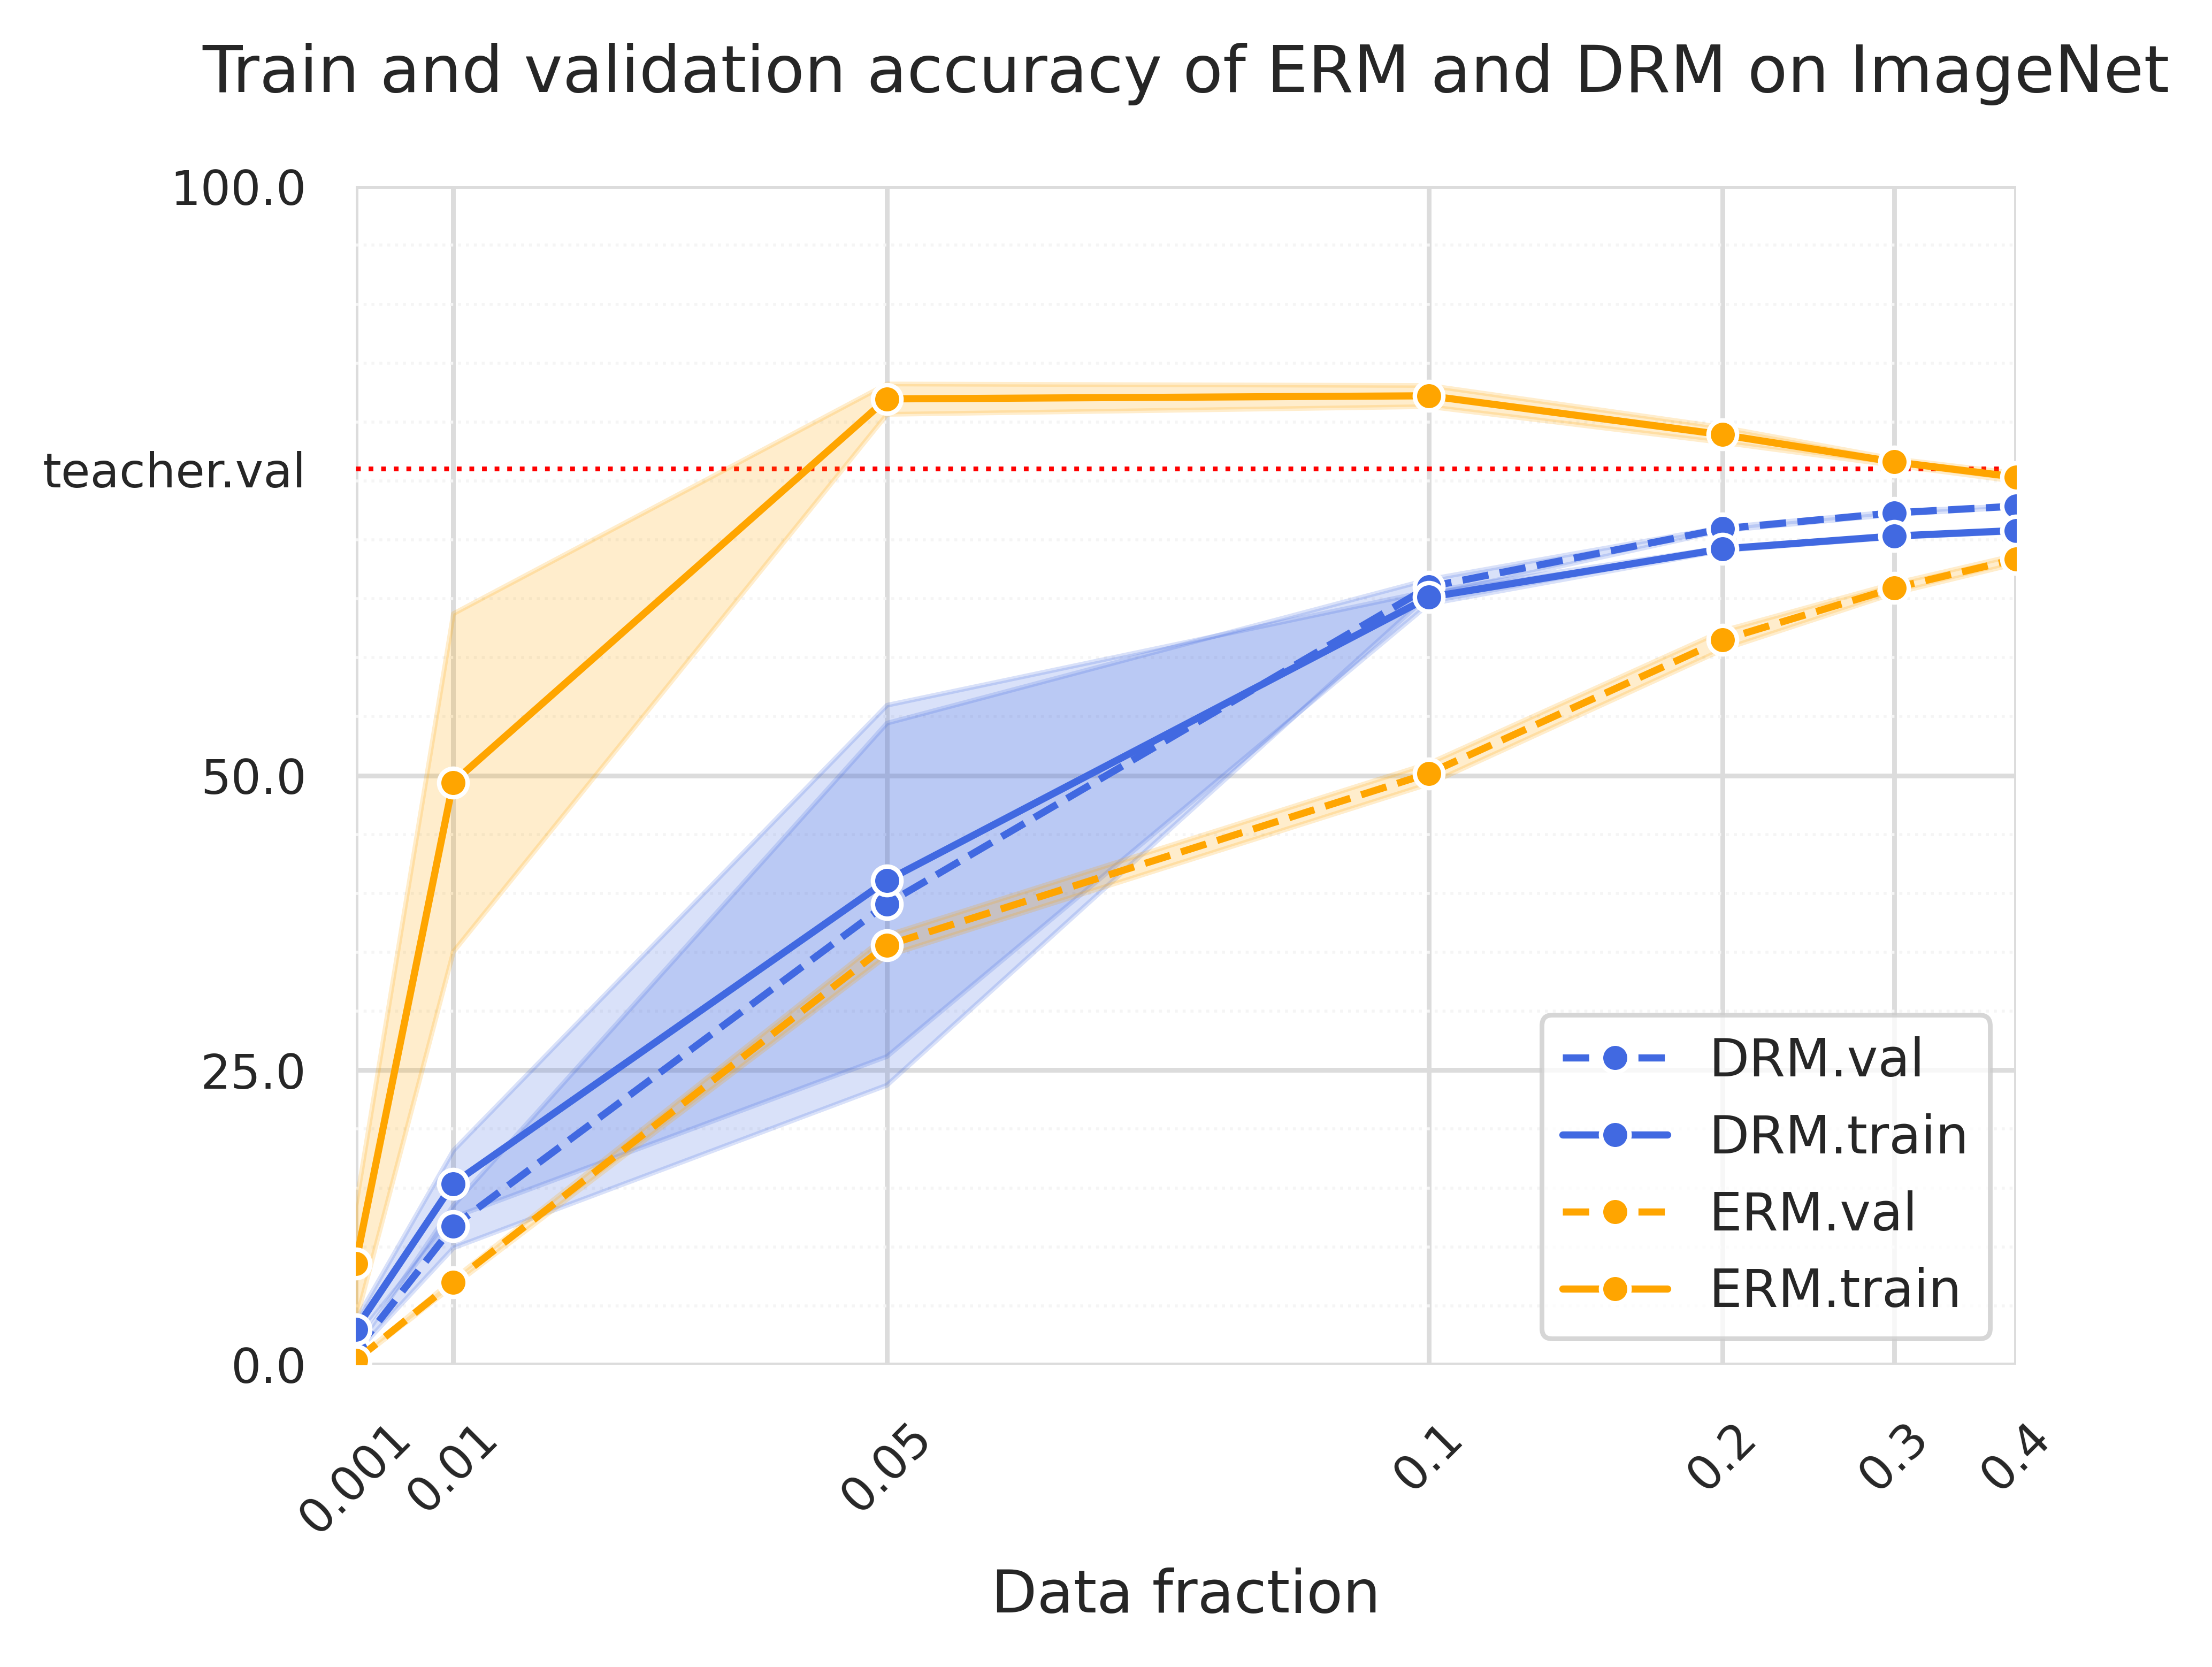

In [13]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']



    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='-', ax=ax, label="distil.train")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='-', ax=ax, label="labels.train")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,0.4])
    ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(working_df['buffer_size_p'].unique())
    ax.set_xticklabels([ f'{l}' for l in working_df['buffer_size_p'].unique()], fontsize=8)
    ax.tick_params(axis='x',  rotation=45)

    yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    plt.yticks(yticks)
    ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher.val', 100.0], fontsize=8)



    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Train and validation accuracy of ERM and DRM on ImageNet", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'Data fraction', fontsize=10, y=+5)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM.val','DRM.train',
                  'ERM.val','ERM.train',
                  'teacher.val','teacher.train'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.8)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.5)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[3]
    b.set_color('red')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


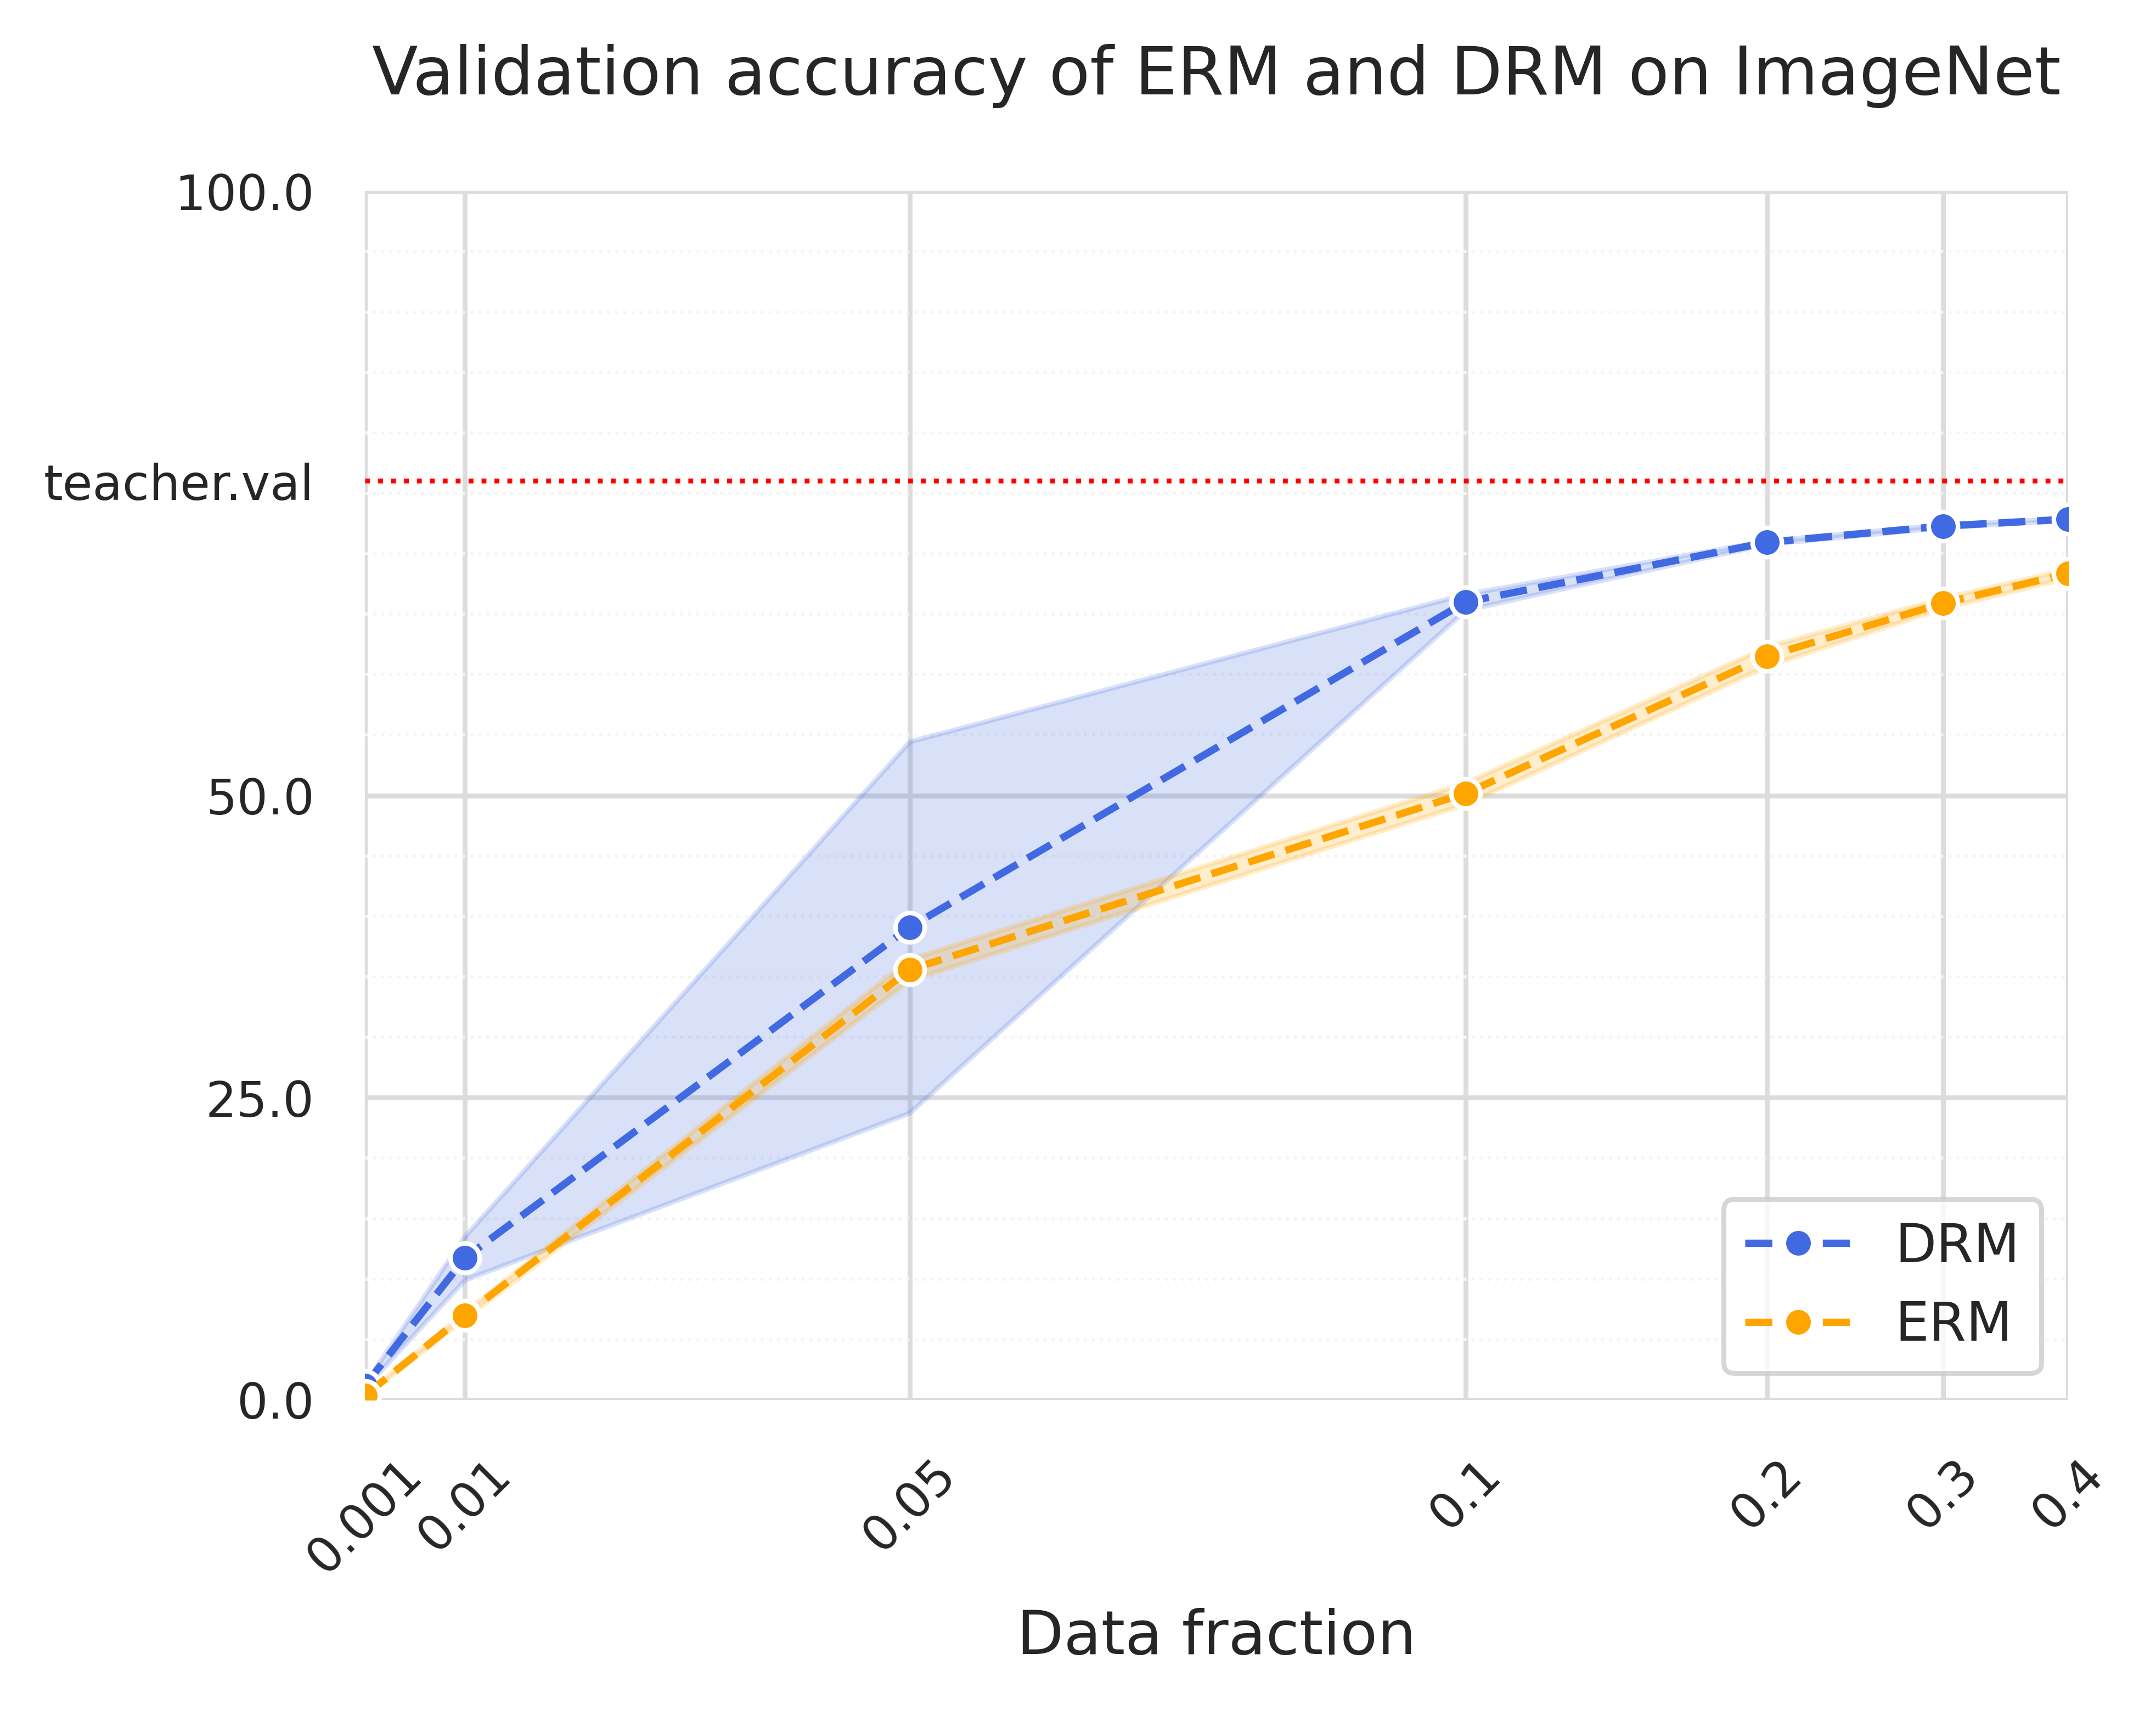

In [14]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']



    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,0.4])
    ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(working_df['buffer_size_p'].unique())
    ax.set_xticklabels([ f'{l}' for l in working_df['buffer_size_p'].unique()], fontsize=8)
    ax.tick_params(axis='x',  rotation=45)

    yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    plt.yticks(yticks)
    ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher.val', 100.0], fontsize=8)



    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Validation accuracy of ERM and DRM on ImageNet", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'Data fraction', fontsize=10, y=+5)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM',
                  'ERM',
                  'teacher'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.8)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.5)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[3]
    b.set_color('red')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


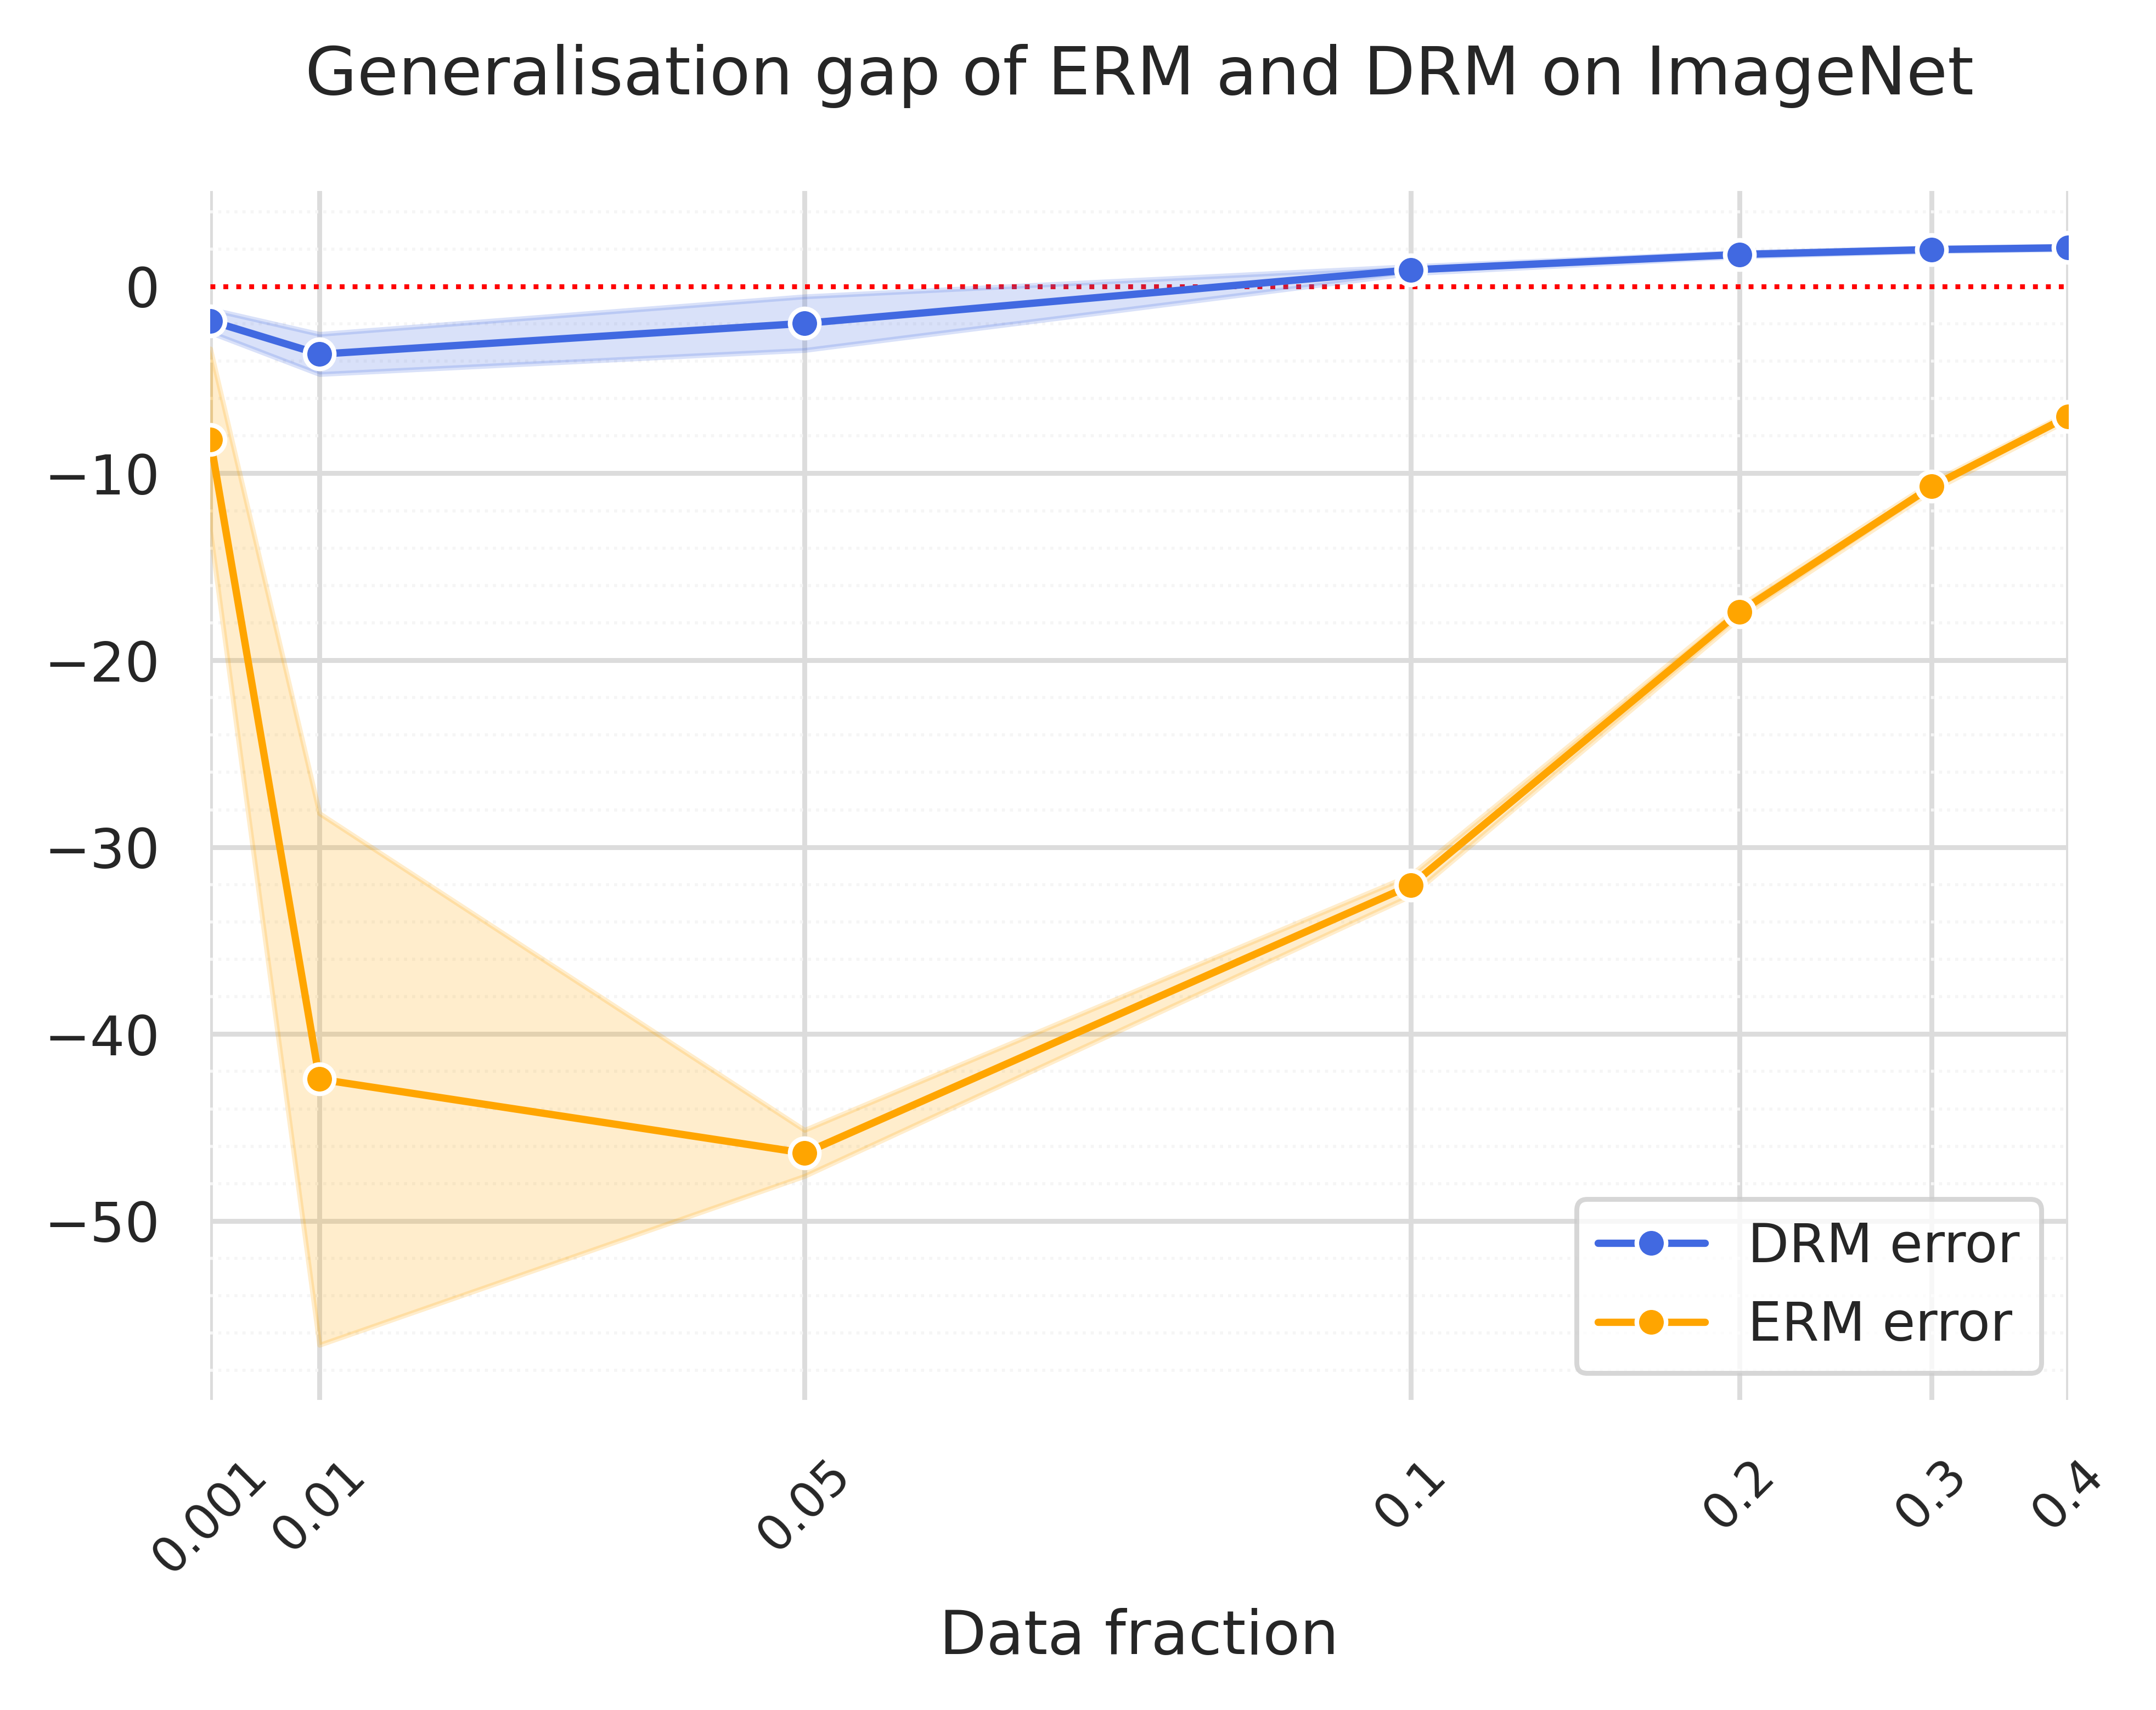

In [15]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']



    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="generalization_gap", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='-', ax=ax, label="DRM error")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="generalization_gap", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='-', ax=ax, label="ERM error")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,0.4])
    #ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(working_df['buffer_size_p'].unique())
    ax.set_xticklabels([ f'{l}' for l in working_df['buffer_size_p'].unique()], fontsize=8)
    ax.tick_params(axis='x',  rotation=45)

    #yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    #plt.yticks(yticks)
    #ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher.val', 100.0], fontsize=8)



    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Generalisation gap of ERM and DRM on ImageNet", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'Data fraction', fontsize=10, y=+5)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM error',
                  'ERM error'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.8)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.5)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[6]
    b.set_color('red')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


## Covariance exploration

In [16]:
from utils.loggers import *
from utils.conf import set_random_seed, get_device
from utils.status import ProgressBar

In [17]:
DEVICE=[1]
device = get_device(DEVICE)

In [18]:
def load_checkpoint(best=False, filename='checkpoint.pth.tar', distributed=False):
    path = base_path() + "/chkpts" + "/" + "imagenet" + "/" + "resnet50/"
    if best: filepath = path + 'model_best.pth.tar'
    else: filepath = path + filename
    if os.path.exists(filepath):
          print(f"Loading existing checkpoint {filepath}")
          checkpoint = torch.load(filepath)
          if filename=='checkpoint_90.pth.tar' and not distributed: # modify Sidak's checkpoint
                new_state_dict = {k.replace('module.','',1):v for (k,v) in checkpoint['state_dict'].items()}
                checkpoint['state_dict'] = new_state_dict
          return checkpoint
    return None 

In [19]:
imagenet_root = "/local/home/stuff/imagenet/"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


train_transform = transforms.Compose([
                            transforms.RandomResizedCrop(224),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            normalize,
                        ])
inference_transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    normalize,
                ])

train_dataset = ImageFolder(imagenet_root+'train', train_transform)
val_dataset = ImageFolder(imagenet_root+'val', inference_transform)

In [20]:
from torch.utils.data import ConcatDataset

In [21]:
all_data = ConcatDataset([train_dataset, val_dataset])
all_data_loader = DataLoader(
        all_data, batch_size=64, shuffle=True,
        num_workers=4, pin_memory=True)

In [22]:
# initialising the model
weights = None
model = resnet50(weights=weights)

chkpt_name = f"checkpoint_90.pth.tar" #sidak's checkpoint
checkpoint = load_checkpoint(best=False, filename=chkpt_name, distributed=False) #TODO: switch best off
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
best_acc1 = checkpoint['best_acc1']

Loading existing checkpoint ./logs//chkpts/imagenet/resnet50/checkpoint_90.pth.tar


In [23]:
weights = None
model = resnet50(weights=weights)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
from torch.nn.utils import parameters_to_vector
theta = parameters_to_vector(model.parameters()).detach()

In [30]:
torch.norm(theta).item()

268.23663330078125

In [25]:
from torch import nn

In [28]:
tot = 0
for n,m in model.named_children():
    #if isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.Linear):
    print(f"Module {n}")
    print(sum([p.numel() for p in m.parameters()]))
    tot +=1
print(tot)

Module conv1
9408
Module bn1
128
Module relu
0
Module maxpool
0
Module layer1
215808
Module layer2
1219584
Module layer3
7098368
Module layer4
14964736
Module avgpool
0
Module fc
2049000
10


In [12]:
x, y = all_data_loader.__iter__().__next__()
x = x.to(device)
for n,m in model.named_modules():
    print(f"Module {n}")
    with torch.no_grad(): 
        if n=='fc':x=torch.flatten(x, 1)
        out = m(x)
    print("IN: ",x.shape)
    print("OUT: ", out.shape)
    print(sum(p.numel() for p in m.parameters()))
    x = out

Module conv1
IN:  torch.Size([64, 3, 224, 224])
OUT:  torch.Size([64, 64, 112, 112])
9408
Module bn1
IN:  torch.Size([64, 64, 112, 112])
OUT:  torch.Size([64, 64, 112, 112])
128
Module relu
IN:  torch.Size([64, 64, 112, 112])
OUT:  torch.Size([64, 64, 112, 112])
0
Module maxpool
IN:  torch.Size([64, 64, 112, 112])
OUT:  torch.Size([64, 64, 56, 56])
0
Module layer1
IN:  torch.Size([64, 64, 56, 56])
OUT:  torch.Size([64, 256, 56, 56])
215808
Module layer2
IN:  torch.Size([64, 256, 56, 56])
OUT:  torch.Size([64, 512, 28, 28])
1219584
Module layer3
IN:  torch.Size([64, 512, 28, 28])
OUT:  torch.Size([64, 1024, 14, 14])
7098368
Module layer4
IN:  torch.Size([64, 1024, 14, 14])
OUT:  torch.Size([64, 2048, 7, 7])
14964736
Module avgpool
IN:  torch.Size([64, 2048, 7, 7])
OUT:  torch.Size([64, 2048, 1, 1])
0
Module fc
IN:  torch.Size([64, 2048])
OUT:  torch.Size([64, 1000])
2049000


In [3]:
a = torch.randn(4, 4)
a.requires_grad = True 
b = a * 3 
b 
#idx = torch.argsort(a, dim=1, descending=True)
#a

tensor([[ 0.0358,  7.5796, -2.1851, -3.1684],
        [-5.1815,  0.3690,  2.7026, -3.8091],
        [ 1.3273, -3.1359,  2.7200, -5.4398],
        [ 1.6102,  3.1359,  2.4219, -2.0800]], grad_fn=<MulBackward0>)

In [4]:
A = torch.rand(10, 4)
_, B = torch.sort(A, descending=True)

In [23]:
B = torch.ones_like(A)
B = torch.multinomial(B,2)
B

tensor([[1, 0],
        [1, 0],
        [3, 1],
        [1, 3],
        [0, 3],
        [3, 1],
        [2, 1],
        [2, 0],
        [1, 0],
        [2, 0]])

In [18]:
torch.randperm(4)

tensor([3, 0, 1, 2])

In [22]:
A

tensor([[0.2863, 0.0912, 0.3332, 0.8146],
        [0.4785, 0.8325, 0.1543, 0.3082],
        [0.5242, 0.7830, 0.2470, 0.5029],
        [0.9958, 0.3832, 0.1513, 0.8709],
        [0.9892, 0.0668, 0.5280, 0.5143],
        [0.8096, 0.9074, 0.4371, 0.7919],
        [0.8517, 0.9794, 0.0613, 0.7241],
        [0.4687, 0.0100, 0.2444, 0.0021],
        [0.0098, 0.6292, 0.7003, 0.6617],
        [0.8010, 0.9793, 0.7033, 0.7052]])

In [21]:
torch.gather(A, 1, B)

tensor([[0.0912, 0.8146],
        [0.3082, 0.8325],
        [0.5242, 0.2470],
        [0.3832, 0.9958],
        [0.9892, 0.5280],
        [0.9074, 0.8096],
        [0.9794, 0.8517],
        [0.0100, 0.2444],
        [0.6292, 0.6617],
        [0.7052, 0.9793]])

In [50]:
B_changed

tensor([[[2, 2, 2, 2],
         [1, 1, 1, 1],
         [3, 3, 3, 3],
         [0, 0, 0, 0]],

        [[3, 3, 3, 3],
         [0, 0, 0, 0],
         [2, 2, 2, 2],
         [1, 1, 1, 1]],

        [[2, 2, 2, 2],
         [1, 1, 1, 1],
         [3, 3, 3, 3],
         [0, 0, 0, 0]],

        [[1, 1, 1, 1],
         [3, 3, 3, 3],
         [0, 0, 0, 0],
         [2, 2, 2, 2]],

        [[3, 3, 3, 3],
         [0, 0, 0, 0],
         [2, 2, 2, 2],
         [1, 1, 1, 1]],

        [[2, 2, 2, 2],
         [3, 3, 3, 3],
         [0, 0, 0, 0],
         [1, 1, 1, 1]],

        [[3, 3, 3, 3],
         [1, 1, 1, 1],
         [0, 0, 0, 0],
         [2, 2, 2, 2]],

        [[3, 3, 3, 3],
         [0, 0, 0, 0],
         [2, 2, 2, 2],
         [1, 1, 1, 1]],

        [[1, 1, 1, 1],
         [3, 3, 3, 3],
         [2, 2, 2, 2],
         [0, 0, 0, 0]],

        [[2, 2, 2, 2],
         [1, 1, 1, 1],
         [3, 3, 3, 3],
         [0, 0, 0, 0]]])

In [47]:
B_changed = torch.tile(B[..., None], (1,A.shape[1]))
A_new = torch.gather(a, dim = 1, index = B_changed)

RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [24]:
torch.take(a, idx[:,:2])

tensor([[ 0.4074, -0.0143],
        [ 0.4074, -0.3782],
        [-0.0143, -0.3782],
        [ 0.4074, -0.0143]])

#### First, we register train accuracy

In [12]:
train_loader = DataLoader(
        train_dataset, batch_size=64, shuffle=True,
        num_workers=4, pin_memory=True)
#TODO: add estimate of the average teacher logits magnitude
progress_bar = ProgressBar(verbose=True)
correct, total = 0.0, 0.0
average_magnitude = 0
for i,data in enumerate(train_loader):
        #if i==3: break
        with torch.no_grad():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            #average_magnitude += (outputs.max(dim=1)[0]-outputs.min(dim=1)[0]).sum(dim=0)
            average_non_max = (outputs.sum(dim=1) - outputs.max(dim=1)[0])/999 # average over the non-max outputs
            average_magnitude += (outputs.max(dim=1)[0] - average_non_max).sum(dim=0)
            _, pred = torch.max(outputs.data, 1)
            correct += torch.sum(pred == labels).item()
            total += labels.shape[0]
        progress_bar.prog(i, len(train_loader), (average_magnitude/total), 'D', (correct / total) * 100)     
acc=(correct / total) * 100
average_magnitude /= total

[ 08-10 | 12:18 ] Task D | epoch 14.51735782623291: |██████████████████████████████████████████████████| 2.87 ep/h | loss: 77.55202874 ||

In [ ]:
# max - min average = 19.93
# max - avg(rest) = 14.52

#### Now we collect all the labels and all the outputs

In [ ]:
# running estimate of the outer products and mean
Y2 = 0; Ymu = 0; t2 = 0; tmu = 0; total=0
C = 1000
progress_bar = ProgressBar(verbose=True)

for i, data in enumerate(all_data_loader):
    #if i==10: break # for testing
    with torch.no_grad():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            labels = torch.nn.functional.one_hot(labels, num_classes=C).view(-1,C,1).to(torch.float64)
            outputs = model(inputs)
            outputs = torch.nn.functional.softmax(outputs.view(-1,C,1))
            total += labels.shape[0]
            Y2 += torch.matmul(labels,labels.permute(0,2,1)).sum(dim=0)
            Ymu += labels.sum(dim=0)
            t2 += torch.matmul(outputs,outputs.permute(0,2,1)).to(torch.float64).sum(dim=0)
            tmu += outputs.sum(dim=0)
    progress_bar.prog(i, len(all_data_loader), -1, 'D', i/(len(all_data_loader)))  
    
# summing over the batch dimension 
Ymu = Ymu/total
tmu = tmu/total
# subtracting the mean and averaging
SigmaY = (Y2 - torch.matmul(Ymu.view(C,1),Ymu.view(1,C)))/((total-1))
SigmaT = (t2 - torch.matmul(tmu.view(C,1),tmu.view(1,C)))/((total-1))

/tmp/ipykernel_2101918/2421696559.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(outputs.view(-1,C,1))
[ 08-01 | 17:58 ] Task D | epoch -1: |██████████████████████████████████████████████████| 1.62 ep/h | loss: 0.99995192 |

In [ ]:
t2.shape

torch.Size([1000, 1000])

In [ ]:
SigmaY = SigmaY.detach().cpu().numpy()
SigmaT = SigmaT.detach().cpu().numpy()

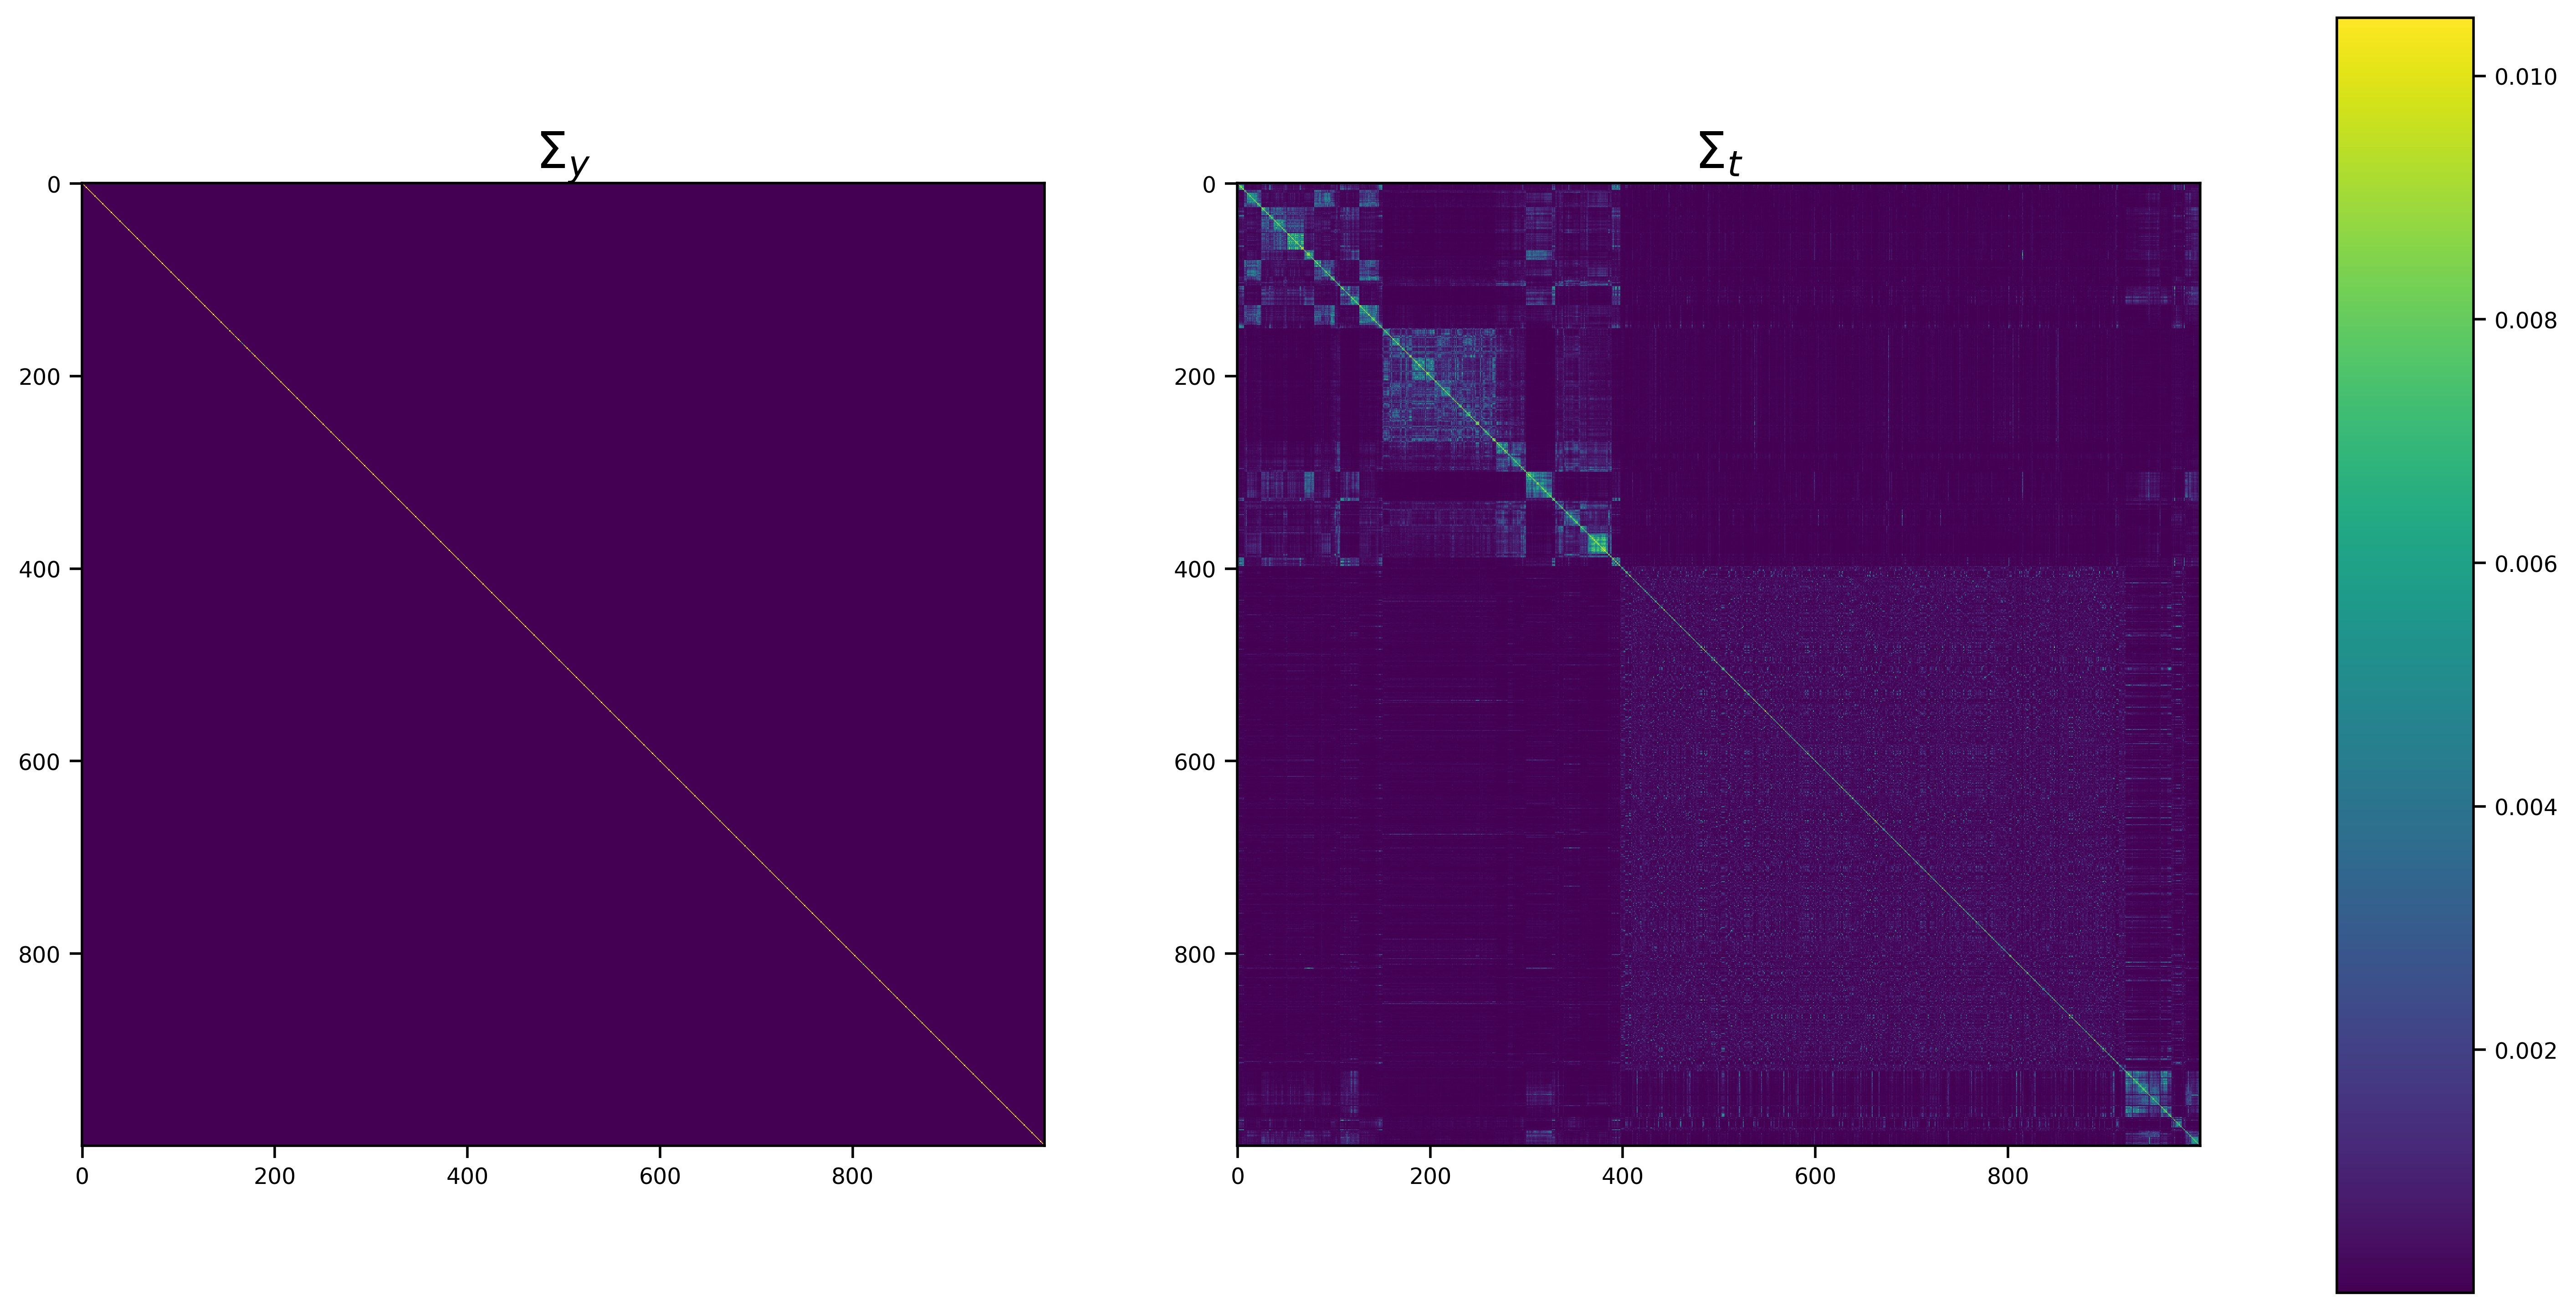

In [ ]:
#M = SigmaT.detach().cpu().numpy()
#assert (M == M.T).sum() == 1000**2
fig, ax = plt.subplots(1,2, figsize=(15,10), dpi=400)

mat = ax[0].matshow(SigmaY)
ax[0].set_title(r'$\Sigma_y$',fontsize=20)
ax[0].tick_params(axis='x', colors='black', top=False, labelbottom=True, labeltop=False)
ax[0].tick_params(axis='y', colors='black', bottom=True, top=False)

mat = ax[1].matshow(SigmaT)
ax[1].set_title(r'$\Sigma_t$',fontsize=20)
ax[1].tick_params(axis='x', colors='black', top=False, labelbottom=True, labeltop=False)
ax[1].tick_params(axis='y', colors='black', bottom=True, top=False)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(mat, cax=cbar_ax, fraction=0.046, pad=0.04)
#fig.colorbar(mat, ax=ax[1], location='right', anchor=(0, 0.5), shrink=0.7)

In [57]:
path=base_path() + "/results" + "/imagenet" + "/resnet50" + "/"
np.save(path + "SigmaY.npy", SigmaY)
np.save(path + "SigmaT.npy", SigmaT)

In [22]:
path=base_path() + "/results" + "/imagenet" + "/resnet50" + "/"
with open(path+ "SigmaY.npy", 'rb') as f:
    SigmaY = np.load(f)
with open(path+ "SigmaT.npy", 'rb') as f:
    SigmaT = np.load(f)

Now we perform an eigenvalue analysis

Text(0.5, 1.0, 'Distribution')

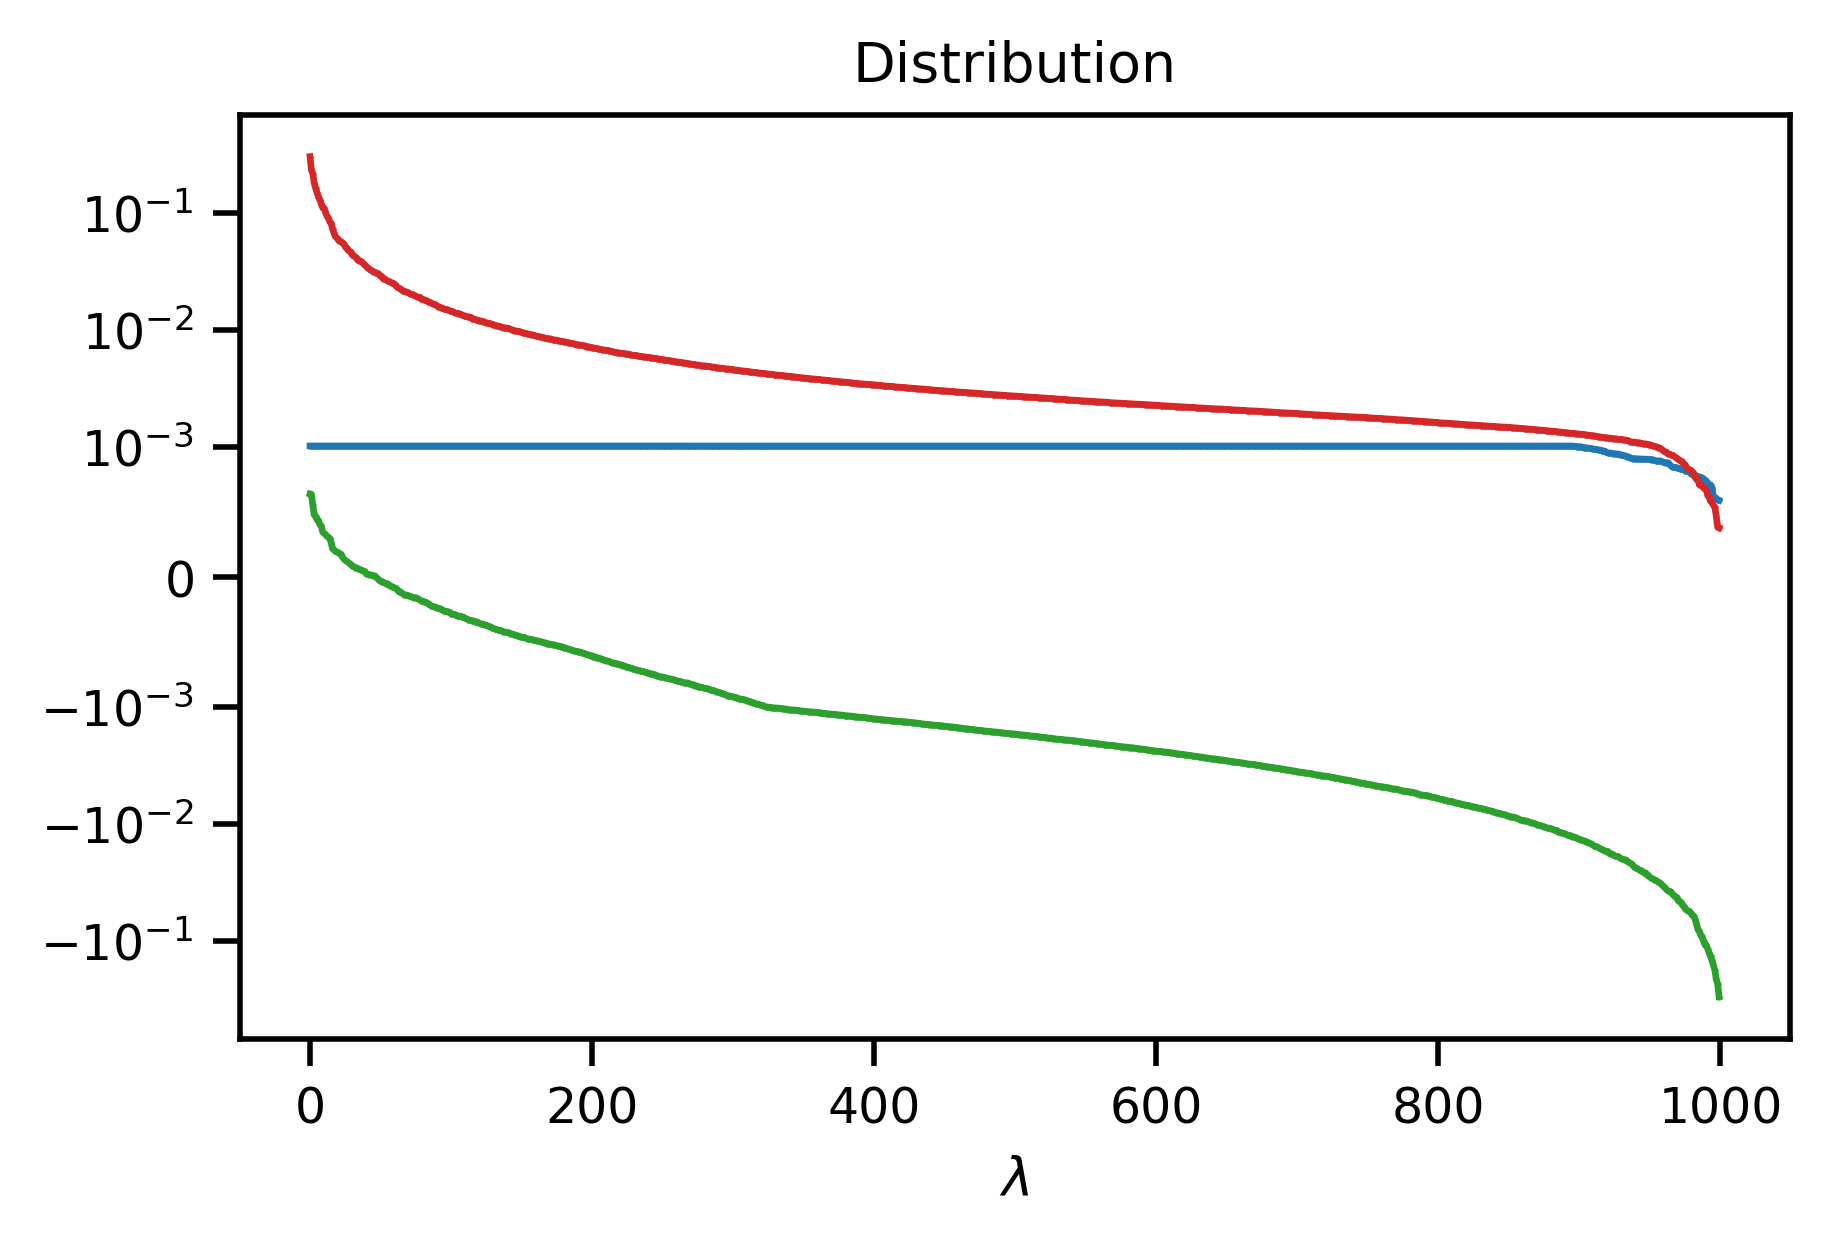

In [23]:
fig, ax = plt.subplots(figsize=(5,3), dpi=400)

L, V = np.linalg.eigh(SigmaY)
#sns.histplot(x=L, ax=ax, binwidth=1., fill=True, color='tab:red')
x = list(range(L.shape[0]))
ax.plot(x, np.flip(L), 'x', linestyle='-', color='tab:blue', ms=0.5)
L, V = np.linalg.eigh(SigmaT)
#sns.histplot(x=L, ax=ax, binwidth=1., fill=True, color='tab:blue')
ax.plot(x, np.flip(L), 'x', linestyle='-', color='tab:red', ms=0.5)
L, V = np.linalg.eigh(SigmaY-SigmaT)
#sns.histplot(x=L, ax=ax, binwidth=1., fill=True, color='tab:blue')
ax.plot(x, np.flip(L), 'x', linestyle='-', color='tab:green', ms=0.5)
#ax.set_xscale('symlog', linthresh=0.001)
ax.set_yscale('symlog', linthresh=10e-4)
#ax.set_yscale('log')
ax.set_xlabel(r'$\lambda$')
ax.set_title('Distribution', fontsize=10)


In [25]:
L, V = np.linalg.eigh(SigmaY-SigmaT)

In [26]:
L.sum()

-6.910937427854297

Loss variance inequality results

In [6]:
logs_path = './logs/results/imagenet/resnet50/LVI.txt'
LVI_results = []
with open(logs_path) as f:
    while line := f.readline():
        LVI_results.append(json.loads(line))

In [7]:
LVI_df = pd.DataFrame(LVI_results)
LVI_df

deltaV    deltaM         ceV
0   0.054165  0.001005  119.317673
1   0.048214 -0.000162   87.803452
2   0.056888 -0.000778   97.328506
3   0.050351 -0.000491   81.199448
4   0.052822 -0.001234   95.889977
..       ...       ...         ...
95  0.053986  0.000037   93.294701
96  0.055877 -0.000317   95.649750
97  0.054854 -0.001404   99.921059
98  0.056321  0.000598  123.797859
99  0.051088 -0.000733   78.876572

[100 rows x 3 columns]

In [8]:
LVI_df['Nmax'] = (2*LVI_df['ceV'] - LVI_df['deltaV'])/(LVI_df['deltaM']**2)
LVI_df

deltaV    deltaM         ceV          Nmax
0   0.054165  0.001005  119.317673  2.363297e+08
1   0.048214 -0.000162   87.803452  6.704057e+09
2   0.056888 -0.000778   97.328506  3.213914e+08
3   0.050351 -0.000491   81.199448  6.736215e+08
4   0.052822 -0.001234   95.889977  1.260082e+08
..       ...       ...         ...           ...
95  0.053986  0.000037   93.294701  1.375075e+11
96  0.055877 -0.000317   95.649750  1.900463e+09
97  0.054854 -0.001404   99.921059  1.013461e+08
98  0.056321  0.000598  123.797859  6.932818e+08
99  0.051088 -0.000733   78.876572  2.933621e+08

[100 rows x 4 columns]

In [39]:
def abline(slope, intercept, x_vals):
    """Return a line from slope and intercept, taking input values in a logspace"""
    y_vals = intercept + slope * x_vals
    return y_vals

In [16]:
LVI_df.loc[0, 'deltaM']

0.0010047522373497486

In [55]:
ys = []
x = np.logspace(2, 14, num=50)
for i in range(len(LVI_df)):
    slope = LVI_df.loc[i, 'deltaM']**2
    intercept = LVI_df.loc[i, 'deltaV'] - 2*LVI_df.loc[i, 'ceV']
    y = abline(slope, intercept, x)
    ys.append(y)

In [143]:
M = 1.2*1e6

In [158]:
np.asarray(ys).shape

(100, 50)

In [175]:
df

variable         value
0            0 -2.385811e+02
1            0 -1.755587e+02
2            0 -1.946001e+02
3            0 -1.623485e+02
4            0 -1.917270e+02
...        ...           ...
4995        49  1.354682e+05
4996        49  1.006281e+07
4997        49  1.971334e+08
4998        49  3.570521e+07
4999        49  5.375663e+07

[5000 rows x 2 columns]

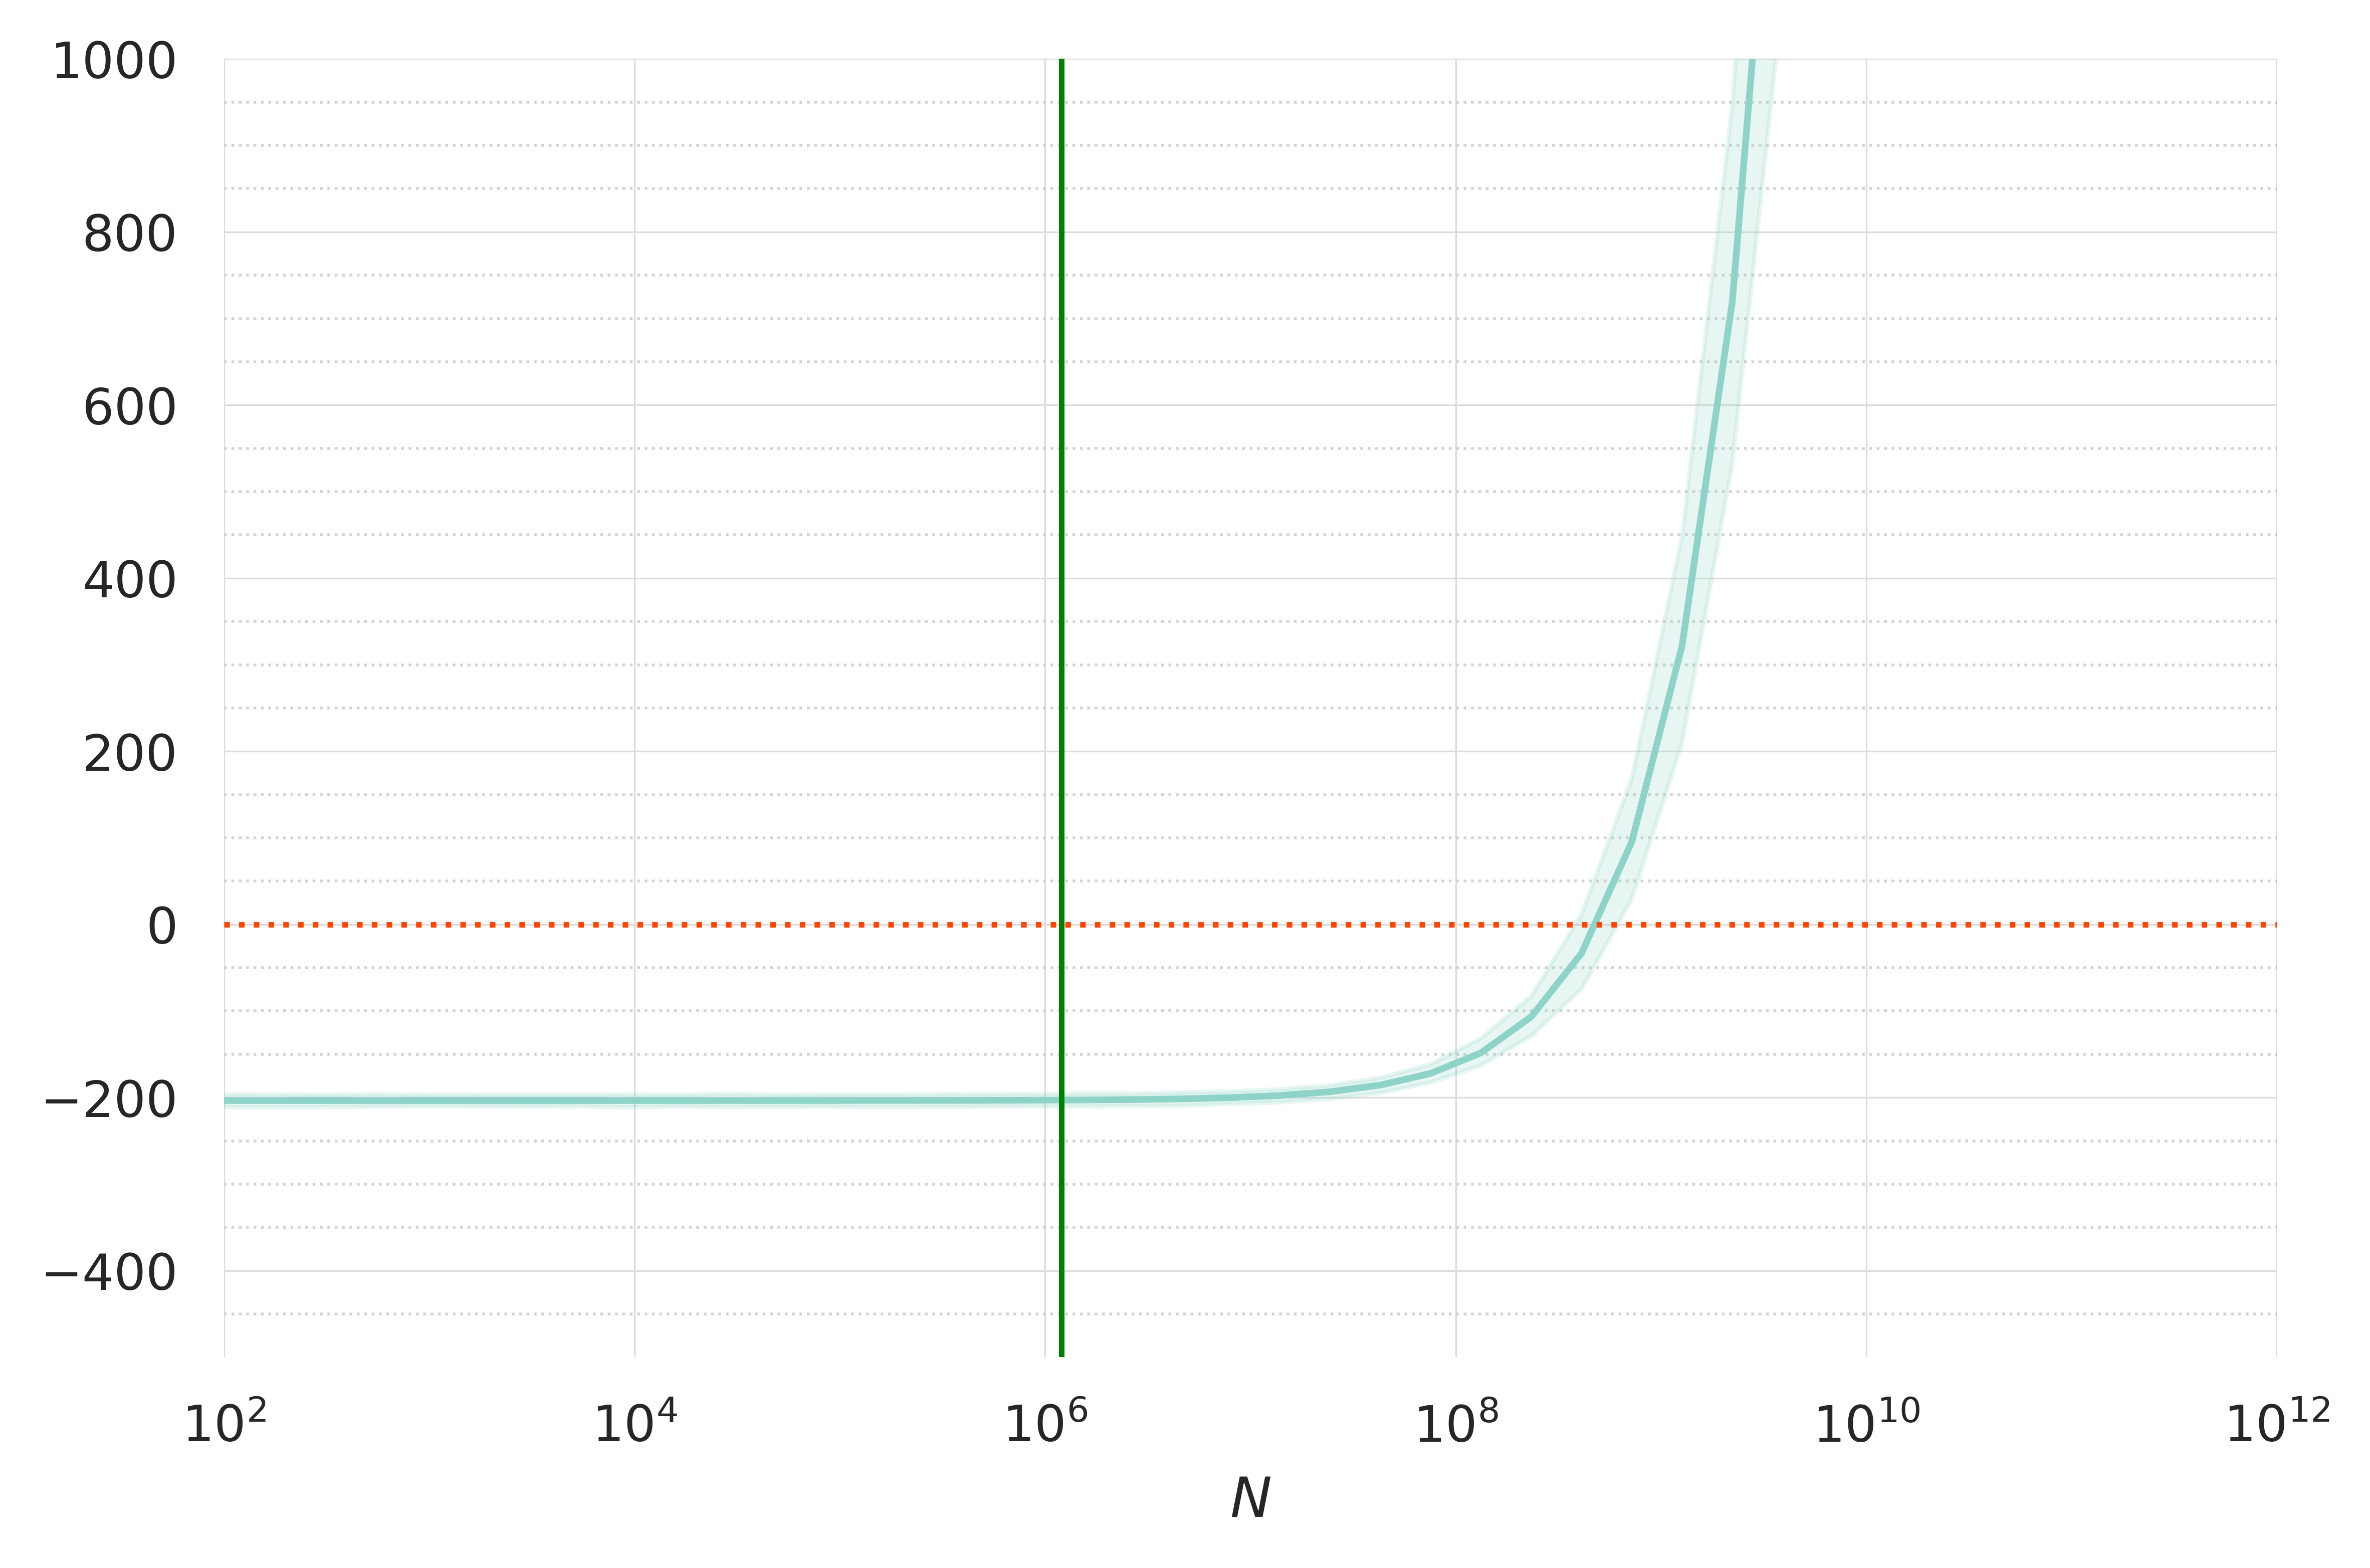

In [194]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    #plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(6,4), sharey=True, dpi=800)
    colors = 'coolwarm'
    
    segs = [np.column_stack([x, y]) for y in ys]
    # line_segments = LineCollection(segs, array=x,
    #                            #linewidths=(0.5, 1, 1.5, 2),
    #                            #cmap=plt.cm.get_cmap(colors),
    #                            colors='skyblue',
    #                            linestyles='solid')
    # ax.add_collection(line_segments)
    #fig.colorbar(line_segments)
    #plt.sci(line_segments)
    df = pd.DataFrame(np.asarray(ys)).melt()
    df['x'] = np.repeat(x, repeats=100)
    sns.lineplot(x="x", y="value", data=df)
    ax.set_xscale('log')
    #ax.set_xticks(x)
    #
    #ax.set_xticklabels([ f'{l}' for l in x], fontsize=8)
    #ax.tick_params(axis='x',  rotation=45)


    #ax.set_yscale('symlog', linthresh=100)
    ax.set_xlim([100,1e12])
    ax.set_ylim([-500,1e3])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_title(f"", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'$N$', fontsize=10, y=+5)

    ax.axhline(0, color="orangered", linewidth=1.0, linestyle=':')
    ax.axvline(M, color="green", linewidth=1.0, linestyle='-')


    # AESTHETICS control 
    #ax.set_facecolor('midnightblue')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.3)
    ax.grid(which='minor', color='lightgrey', linestyle=':', linewidth=0.5)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    
    plt.tight_layout()
    plt.show()
